# **Flower Classification Competition (30%)**
For this competition, we will use the Flower Recognition. This dataset contains 4317 images of flowers. The data collection is based on the data from flickr, google images, yandex images. The aim is to recognize flower species from a photo.  

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Note that for this dataset the photos are not all at a fixed size, they have different proportions.

We provide baseline code that includes the following features:

*   Loading and Analysing the Flowers dataset using torchvision.
*   Providing some augmentations (on loading)
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.
*   Generate prediction for the random test image(s).

The following improvements could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
2. Use of a new loss function.
3. Additional/better data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other variants.

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark
###Acc_mark 10:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

###Efficiency mark 10:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 30:
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]

In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: Nethmi Ranathunga, Emily Carey
### Student ID: a1895261, a1851030
### Comptetion Name: Flowers Classification Competition
### Final Results:
### ACC:89.00%         GFLOPs:4.11058
##################################################################################################################################

In [ ]:
# Importing libraries.

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional #added
from torchvision import models #added
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

In [ ]:
# Performing Image Transformations.

train_transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
      #  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
data_directory = '/content/drive/MyDrive/Datasets/flower/flowers'
dataset=datasets.ImageFolder(root=data_directory,transform=train_transform)
dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /content/drive/MyDrive/Datasets/flower/flowers
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Checking the flower class types.
class_names=dataset.classes
print(class_names)
print(len(class_names))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
5


In [ ]:
# Train and Test data split.
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

In [ ]:
# To check wether Google Colab GPU has been assigned/not.
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader=DataLoader(train_data,batch_size=8,shuffle=True)
test_loader=DataLoader(test_data,batch_size=8)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
print(len(train_data))
print(len(test_data))

3453
864


In [ ]:
# Preview of the datasets.
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [2 2 0 4 4 0 1 4]
Class: rose rose daisy tulip tulip daisy dandelion tulip


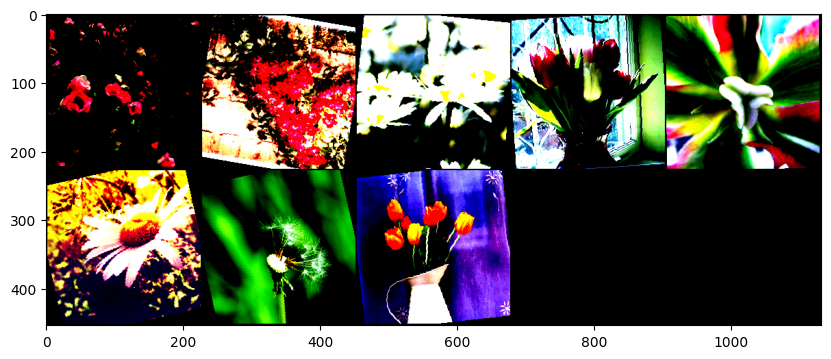

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
# Inverse Normalization.
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                     std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

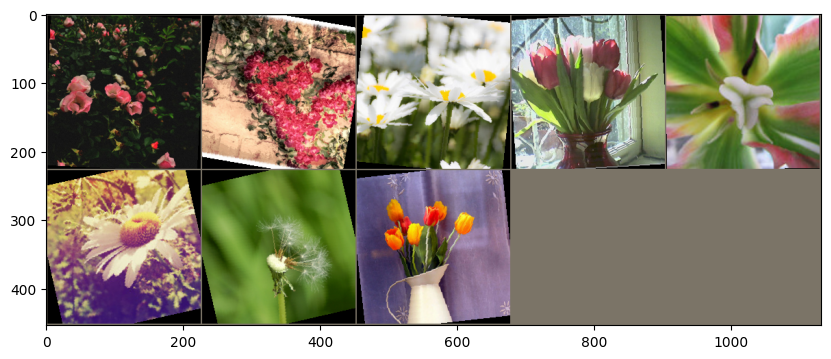

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
#ADDED
# define focal loss class

class FocalLoss(nn.Module):
    def __init__(self,
                 alpha: Optional[torch.Tensor] = None,
                 gamma: float = 2.0,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.nll_loss = nn.NLLLoss(weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x, y):
        log_pt = F.log_softmax(x, dim=1)
        pt = torch.exp(log_pt)
        log_pt = log_pt.gather(1, y.view(-1, 1)).squeeze(1)
        pt = pt.gather(1, y.view(-1, 1)).squeeze(1)
        loss = -self.alpha[y] * (1 - pt) ** self.gamma * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [ ]:
# #ADDED - architectural change - residual linear block
class ResidualLinearBlock(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.block = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_dim, output_dim)
    )
    self.shortcut = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.block(x) + self.shortcut(x)


In [ ]:
class ResNetFlowerModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base_model = models.resnet50(pretrained=True)
        base_model = base_model.to(device)

        # Freeze pretrained layers
        for param in base_model.parameters():
            param.requires_grad = False

        # Replace final FC layer with custom residual block
        base_model.fc = ResidualLinearBlock(2048, 500, num_classes)
        self.network = base_model

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, name = batch
        out = self(images)
        return F.cross_entropy(out, name)

    def validation_step(self, batch):
        images, name = batch
        out = self(images)
        loss = F.cross_entropy(out, name)
        acc = (torch.argmax(out, dim=1) == labels).float().mean()
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accs = [x['val_acc'] for x in outputs]
        return {
            'val_loss': torch.stack(batch_losses).mean().item(),
            'val_acc': torch.stack(batch_accs).mean().item()
        }

    def epoch_end(self, epoch, result):  #
        print(f"Epoch [{epoch+1}], train_loss: {result['train_loss']:.4f}, "
              f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


In [ ]:
import time
import torch.optim as optim



start_time = time.time()
model = ResNetFlowerModel(num_classes=5).to(device)


optimizer = optim.SGD(model.network.fc.parameters(), lr=0.001, momentum=0.9)
criterion = FocalLoss(alpha=torch.tensor([1, 1, 2, 1, 1], dtype=torch.float32, device=device), gamma=2)

train_losses = []
test_losses = []
train_correct = []
test_correct = []

epochs = 30

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%10==0:
            print(f"epoch: {i} loss: {loss.item():.4f} batch: {b} accuracy: {trn_corr.item()*100/(b*batch_size):7.3f}%")



    train_losses.append(loss.item())
    train_correct.append(trn_corr.item() / len(train_loader.dataset))
    model.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            y_val = model(X_test)
            loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr

        loss = loss.detach().cpu().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr.cpu().numpy())
    print(f'epoch: {i}, test accuracy: {tst_corr*100/len(test_data):7.3f}%')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')



epoch: 0 loss: 0.9561 batch: 10 accuracy:  26.250%
epoch: 0 loss: 0.5221 batch: 20 accuracy:  35.000%
epoch: 0 loss: 1.7720 batch: 30 accuracy:  43.333%
epoch: 0 loss: 0.2596 batch: 40 accuracy:  49.375%
epoch: 0 loss: 0.4310 batch: 50 accuracy:  51.250%
epoch: 0 loss: 1.2876 batch: 60 accuracy:  53.125%
epoch: 0 loss: 0.5325 batch: 70 accuracy:  54.286%
epoch: 0 loss: 0.1850 batch: 80 accuracy:  57.031%
epoch: 0 loss: 0.3536 batch: 90 accuracy:  59.306%
epoch: 0 loss: 0.3189 batch: 100 accuracy:  60.250%
epoch: 0 loss: 1.1438 batch: 110 accuracy:  61.477%
epoch: 0 loss: 1.1100 batch: 120 accuracy:  61.979%
epoch: 0 loss: 0.4181 batch: 130 accuracy:  63.365%
epoch: 0 loss: 0.4713 batch: 140 accuracy:  64.018%
epoch: 0 loss: 1.0556 batch: 150 accuracy:  64.000%
epoch: 0 loss: 0.4434 batch: 160 accuracy:  64.219%
epoch: 0 loss: 0.2592 batch: 170 accuracy:  65.368%
epoch: 0 loss: 0.0432 batch: 180 accuracy:  65.764%
epoch: 0 loss: 0.0937 batch: 190 accuracy:  65.987%
epoch: 0 loss: 0.6471

__COUNT PARAMETERS__

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = ResNetFlowerModel(num_classes=5).to(device)
print(f"Total Trainable Parameters: {count_parameters(model):,}")

Total Trainable Parameters: 1,038,250


__TRAINING LOSS VS TEST LOSS PER EPOCH__

[1.490334391593933,
 0.08944802731275558,
 0.44631096720695496,
 0.533277690410614,
 1.0550403594970703,
 0.5432459712028503,
 0.898073136806488,
 1.1420806646347046,
 0.09323965013027191,
 0.6609362363815308,
 0.0016257710522040725,
 0.18657882511615753,
 0.09122998267412186,
 0.0013647762825712562,
 0.007810262497514486,
 0.09104019403457642,
 0.050325747579336166,
 0.1948135793209076,
 0.0595608651638031,
 0.058359574526548386,
 0.0007576301577500999,
 0.8021712303161621,
 0.4141075611114502,
 0.006429092492908239,
 0.2847963273525238,
 0.048081349581480026,
 0.6852452158927917,
 0.41382119059562683,
 0.15943415462970734,
 0.02248590812087059]

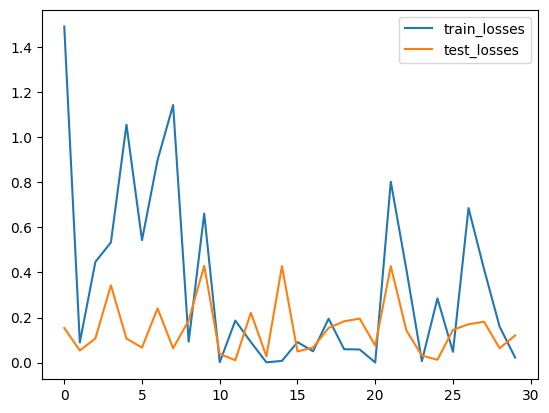

In [ ]:
# Plotting loss over time.
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()
train_losses

__TRAIN VS TEST ACCURACY OVER TIME__

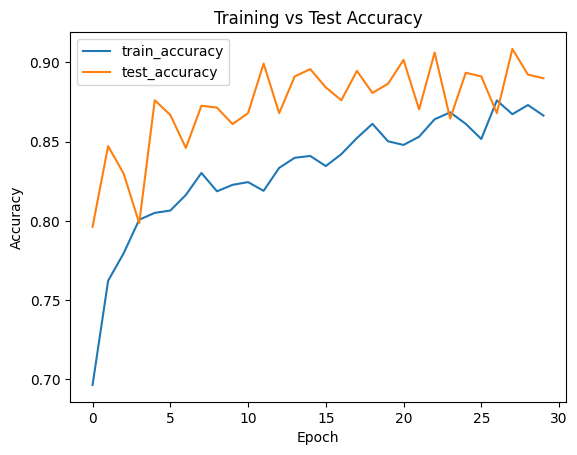

In [ ]:

plt.plot(train_correct, label="train_accuracy")
plt.plot(np.array(test_correct) / len(test_loader.dataset), label="test_accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.show()



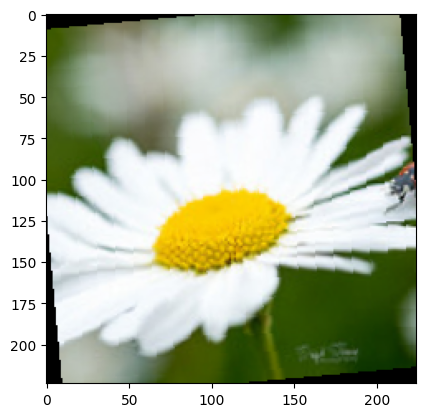

In [ ]:
x=100
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
test_data[x][0].shape
test_data[x][0].device

device(type='cpu')

In [ ]:
# Prediction for one of the samples.
model.eval()
with torch.no_grad():
    new_pred=model(to_device(test_data[x][0].view(1,3,224,224),device)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 3 sunflower


##FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [ ]:
# we use fvcore to calculate the FLOPs
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=6a8c8531a8c346534e839a3a741e5798b612116c5edf7cfc8d950abfad7254e4
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=e7809afad861206bc4cd23a48e75a684e1cf8c9bed94142e2670ab8995e3dc58
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [ ]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 3, 224, 224).to(device) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 5
model = ResNetFlowerModel(num_classes).to(device)
model.eval()
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

FLOPs: 4.11050 GFLOPs


__EFFICIENCY AND FINAL TEST ACCURACY__

In [ ]:
gflops = 4.11050
final = test_correct[-1] * 100 / len(test_loader.dataset)
efficiency = final / gflops

print(f"Final Test Accuracy: {final:.2f}%")
print(f"Efficiency Score: {efficiency:.2f}")


Final Test Accuracy: 89.00%
Efficiency Score: 21.65
